In [1]:
%reset
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
import numpy as np
import pandas as pd
from scipy import signal
import statistics as stats
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from scipy import stats
import scipy.sparse as sparse

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
def weighted_average(distribution, weights):
    return round(sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights),2)

def import_csv(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1]]
                data.append(columns)

    return data

def import_csv2(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10] ]
                data.append(columns)

    return data

def import_csv3(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8],
                           row[9], row[10], row[11] ]
                data.append(columns)

    return data

def import_csv4(csvfilename):
    data = []
    with open(csvfilename, "r", encoding="utf-8", errors="ignore") as scraped:
        reader = csv.reader(scraped, delimiter=' ', skipinitialspace='True')
        next(reader)
        row_index = 0
        for row in reader:
            if row:  # avoid blank lines
                #row_index += 1
                #columns = [str(row_index), row[0], row[1], row[2], row[3]]
                columns = [row[0], row[1], row[2], row[3], row[4]]
                data.append(columns)

    return data

In [3]:
tcp_cca = (['TcpCubic', 'TcpBbr',
            'TcpQtColFair_1.2minRTT', 'TcpQtColFair_1.5minRTT'
           ])
BDP = 172
buffer_array = [1, 17, 34, 86, 172, 259, 345] 
print(buffer_array, tcp_cca)

[1, 17, 34, 86, 172, 259, 345] ['TcpCubic', 'TcpBbr', 'TcpQtColFair_1.2minRTT', 'TcpQtColFair_1.5minRTT']


In [4]:
num_flows = 5
cwnd = {}
agg_cwnd_mean = {}
inflight = {}
rtt = {}

for algorithm in tcp_cca:
    cwnd[algorithm] = {}
    agg_cwnd_mean[algorithm] = {}
    inflight[algorithm] = {}
    rtt[algorithm] = {}

    for buffer_size in buffer_array:
        cwnd[algorithm][buffer_size] = {}
        agg_cwnd_mean[algorithm][buffer_size] = {}
        inflight[algorithm][buffer_size] = {}
        rtt[algorithm][buffer_size] = {}

In [5]:
cwnd_files = []
agg_cwnd_files = []
inflight_files = []
rtt_files = []
                                               
for algorithm in tcp_cca:
    print(algorithm)
    cwnd_sim_files = []
    agg_cwnd_files_ = []
    
    for buffer_size in buffer_array: 
        agg_cwnd_files_.append("../results/qt_bdp_comparison/" + str(algorithm) + "/" + 
                        str(num_flows)  + "-flows/100Mbps-20ms/" + str(buffer_size) + "p-btlqueue/" + 
                        algorithm + "-" + str(num_flows) + "-flows-100Mbps-20ms-" + str(buffer_size) +
                        "p-" + "Agg" + "-cwnd.data")
    
    agg_cwnd_files.append(agg_cwnd_files_)

TcpCubic
TcpBbr
TcpQtColFair_1.2minRTT
TcpQtColFair_1.5minRTT


In [6]:
for algorithm in tcp_cca:
    cwnd[algorithm] = {}
    agg_cwnd_mean[algorithm] = {}
    inflight[algorithm] = {}
    rtt[algorithm] = {}

    for buffer_size in buffer_array:
        cwnd[algorithm][buffer_size] = {}
        agg_cwnd_mean[algorithm][buffer_size] = {}
        inflight[algorithm][buffer_size] = {}
        rtt[algorithm][buffer_size] = {}
        
        agg_cwnd_mean[algorithm][buffer_size] = {'agg_inflight': list(),
                    'aveRtt': list(), 'agg_aveThruput': list(), 'agg_aveGoodput': list(), 'PLR': list()}
    print(algorithm)
    
agg_inflight_mean = []
agg_inflight = []
aveRtt_mean = []
aveRtt = []
agg_aveThruput_last = []
agg_aveGoodput_last = []
PLR_last = []

for algorithm  in tcp_cca:
    index_alg = tcp_cca.index(algorithm)

    agg_inflight_mean_ = []
    aveRtt_mean_ = []
    agg_aveThruput_last_ = []
    agg_aveGoodput_last_ = []
    PLR_last_ = []    
    
    for buffer_size in buffer_array:
        index_buf = buffer_array.index(buffer_size)
        agg_cwnd_data_in = import_csv3(agg_cwnd_files[index_alg][index_buf])

        agg_inflight_ = []
        agg_inflight__ = []
        aveRtt_ = []
        aveRtt__ = []
        agg_aveThruput_ = []
        agg_aveGoodput_ = []
        agg_TxPkts_ = []
        agg_ReTxPkts_ = []
        PLR_ = []
        
        for row in agg_cwnd_data_in: 
            agg_inflight_.append(float(row[2]))
            aveRtt_.append(float(row[3]))
            agg_aveThruput_.append(float(row[5]))
            agg_aveGoodput_.append(float(row[7]))
            agg_TxPkts_.append(row[8])
            agg_ReTxPkts_.append(row[9])
            if float(row[8]) > 0:
                PLR_.append(float(row[9])/float(row[8]))
                        
        agg_inflight_mean_.append(pd.DataFrame(agg_inflight_).astype('float').mean()/1448)
        aveRtt_mean_.append(pd.DataFrame(aveRtt_).astype('float').mean())
        agg_aveThruput = pd.DataFrame(agg_aveThruput_).astype('float')
        agg_aveThruput_last_.append(agg_aveThruput[0][len(agg_aveThruput)-1])
        agg_aveGoodput = pd.DataFrame(agg_aveGoodput_).astype('float')
        agg_aveGoodput_last_.append(agg_aveGoodput[0][len(agg_aveGoodput)-1])
        PLR_last_.append(PLR_[-1])
        aveRtt__.append(pd.DataFrame(aveRtt_).astype('float'))
        agg_inflight__.append(pd.DataFrame( agg_inflight_).astype('float'))

    agg_inflight_mean.append(np.array(agg_inflight_mean_))
    aveRtt_mean.append(np.array(aveRtt_mean_))
    agg_aveThruput_last.append(agg_aveThruput_last_)
    agg_aveGoodput_last.append(agg_aveGoodput_last_)
    PLR_last.append(PLR_last_)
    aveRtt.append(aveRtt__)
    agg_inflight.append(agg_inflight__)

TcpCubic
TcpBbr
TcpQtColFair_1.2minRTT
TcpQtColFair_1.5minRTT


/tmp/ipykernel_22133/2874736589.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


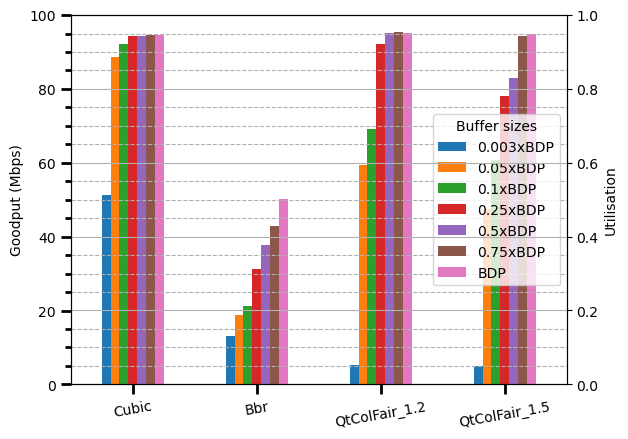

In [26]:
goodput1 = [agg_aveGoodput_last[0][0], agg_aveGoodput_last[1][0], agg_aveGoodput_last[2][0], 
         agg_aveGoodput_last[3][0]]
goodput17 = [agg_aveGoodput_last[0][1], agg_aveGoodput_last[1][1], agg_aveGoodput_last[2][1], 
         agg_aveGoodput_last[3][1]]
goodput34 = [agg_aveGoodput_last[0][2], agg_aveGoodput_last[1][2], agg_aveGoodput_last[2][2], 
         agg_aveGoodput_last[3][2]]
goodput86 = [agg_aveGoodput_last[0][3], agg_aveGoodput_last[1][3], agg_aveGoodput_last[2][3], 
         agg_aveGoodput_last[3][3]]
goodput172 = [agg_aveGoodput_last[0][4], agg_aveGoodput_last[1][4], agg_aveGoodput_last[2][4], 
         agg_aveGoodput_last[3][4]]
goodput259 = [agg_aveGoodput_last[0][5], agg_aveGoodput_last[1][5], agg_aveGoodput_last[2][5], 
         agg_aveGoodput_last[3][5]]
goodput345 = [agg_aveGoodput_last[0][6], agg_aveGoodput_last[1][6], agg_aveGoodput_last[2][6], 
         agg_aveGoodput_last[3][6]]

index = [
            tcp_cca[0].replace('Tcp',''),
            tcp_cca[1].replace('Tcp',''),
            tcp_cca[2].replace('minRTT','').replace('Tcp',''),
            tcp_cca[3].replace('minRTT','').replace('Tcp','')
        ]

df = pd.DataFrame({'0': goodput1, '1': goodput17, '2': goodput34, '3': goodput86, 
                   '4': goodput172, '5': goodput259, '6': goodput345
                  }, index=index)

ax1 = df.plot.bar(rot=10)
ax2 = ax1.twinx()

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

ax1.legend(['0.003xBDP', '0.05xBDP', '0.1xBDP', '0.25xBDP', '0.5xBDP', '0.75xBDP', 'BDP'], 
           loc ="center right", title = 'Buffer sizes')

ax1.set_ylabel('Goodput (Mbps)')
ax2.set_ylabel('Utilisation')
plt.grid(True)

plt.savefig('multiple_bdp_comparison/5_flows_bdpshallow_goodput_barchart.png', transparent=True)
plt.show()

/tmp/ipykernel_22133/1292446140.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


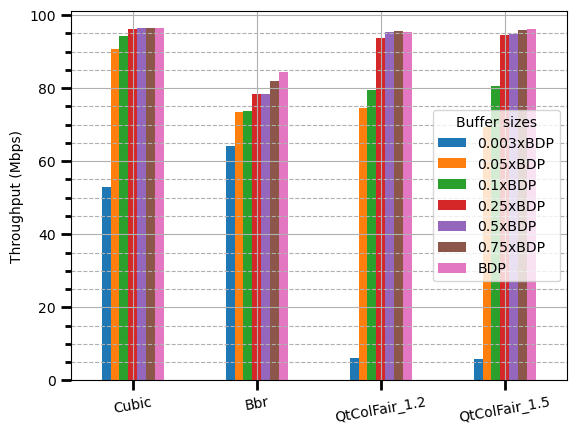

In [14]:
thruput1 = [agg_aveThruput_last[0][0], agg_aveThruput_last[1][0], agg_aveThruput_last[2][0], 
         agg_aveThruput_last[3][0]]
thruput17 = [agg_aveThruput_last[0][1], agg_aveThruput_last[1][1], agg_aveThruput_last[2][1], 
         agg_aveThruput_last[3][1]]
thruput34 = [agg_aveThruput_last[0][2], agg_aveThruput_last[1][2], agg_aveThruput_last[2][2], 
         agg_aveThruput_last[3][2]]
thruput86 = [agg_aveThruput_last[0][3], agg_aveThruput_last[1][3], agg_aveThruput_last[2][3], 
         agg_aveThruput_last[3][3]]
thruput172 = [agg_aveThruput_last[0][4], agg_aveThruput_last[1][4], agg_aveThruput_last[2][4], 
         agg_aveThruput_last[3][4]]
thruput259 = [agg_aveThruput_last[0][5], agg_aveThruput_last[1][5], agg_aveThruput_last[2][5], 
         agg_aveThruput_last[3][5]]
thruput345 = [agg_aveThruput_last[0][6], agg_aveThruput_last[1][6], agg_aveThruput_last[2][6], 
         agg_aveThruput_last[3][6]]

index = [
            tcp_cca[0].replace('Tcp',''),
            tcp_cca[1].replace('Tcp',''),
            tcp_cca[2].replace('minRTT','').replace('Tcp',''),
            tcp_cca[3].replace('minRTT','').replace('Tcp','')
        ]

df = pd.DataFrame({'0': thruput1, '1': thruput17, '2': thruput34, '3': thruput86, 
                   '4': thruput172, '5': thruput259, '6': thruput345
                  }, index=index)

ax1 = df.plot.bar(rot=10)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.legend(['0.003xBDP', '0.05xBDP', '0.1xBDP', '0.25xBDP', '0.5xBDP', '0.75xBDP', 'BDP'], 
           loc ="center right", title = 'Buffer sizes')

plt.ylabel(r'Throughput (Mbps)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(40,97)
#plt.xlim(0,15)
plt.grid(True)

plt.savefig('multiple_bdp_comparison/5_flows_bdpshallow_thruput_barchart.png', transparent=True)
plt.show()

/tmp/ipykernel_22133/1187268682.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


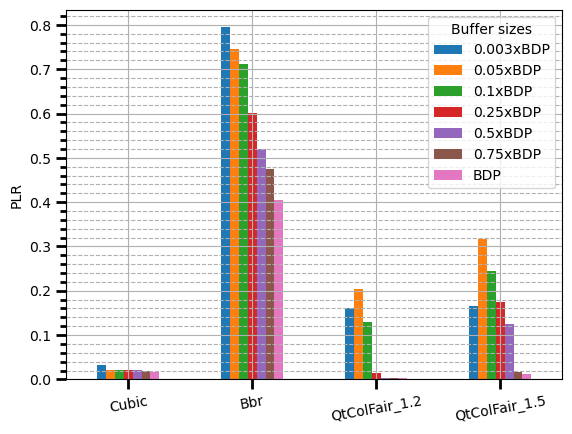

In [15]:
plr1 = [PLR_last[0][0], PLR_last[1][0], PLR_last[2][0], 
         PLR_last[3][0]]
plr17 = [PLR_last[0][1], PLR_last[1][1], PLR_last[2][1], 
         PLR_last[3][1]]
plr34 = [PLR_last[0][2], PLR_last[1][2], PLR_last[2][2], 
         PLR_last[3][2]]
plr86 = [PLR_last[0][3], PLR_last[1][3], PLR_last[2][3], 
         PLR_last[3][3]]
plr172 = [PLR_last[0][4], PLR_last[1][4], PLR_last[2][4], 
         PLR_last[3][4]]
plr259 = [PLR_last[0][5], PLR_last[1][5], PLR_last[2][5], 
         PLR_last[3][5]]
plr345 = [PLR_last[0][6], PLR_last[1][6], PLR_last[2][6], 
         PLR_last[3][6]]

index = [
            tcp_cca[0].replace('Tcp',''),
            tcp_cca[1].replace('Tcp',''),
            tcp_cca[2].replace('minRTT','').replace('Tcp',''),
            tcp_cca[3].replace('minRTT','').replace('Tcp','')
        ]

df = pd.DataFrame({'0': plr1, '1': plr17, '2': plr34, '3': plr86, 
                   '4': plr172, '5': plr259, '6': plr345
                  }, index=index)

ax1 = df.plot.bar(rot=10)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.legend(['0.003xBDP', '0.05xBDP', '0.1xBDP', '0.25xBDP', '0.5xBDP', '0.75xBDP', 'BDP'], 
           loc ="best", title = 'Buffer sizes')

plt.ylabel(r'PLR')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
#plt.ylim(0,0.1)
#plt.xlim(0,15)
plt.grid(True)

plt.savefig('multiple_bdp_comparison/5_flows_bdpshallow_PLR_barchart.png', transparent=True)
plt.show()

/tmp/ipykernel_22133/3551917898.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


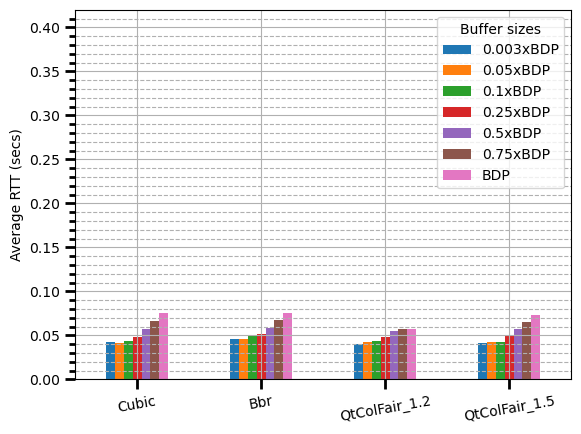

In [16]:
rtt1 = [aveRtt_mean[0][0][0], aveRtt_mean[1][0][0], aveRtt_mean[2][0][0], 
         aveRtt_mean[3][0][0]]
rtt17 = [aveRtt_mean[0][1][0], aveRtt_mean[1][1][0], aveRtt_mean[2][1][0], 
         aveRtt_mean[3][1][0]]
rtt34 = [aveRtt_mean[0][2][0], aveRtt_mean[1][2][0], aveRtt_mean[2][2][0], 
         aveRtt_mean[3][2][0]]
rtt86 = [aveRtt_mean[0][3][0], aveRtt_mean[1][3][0], aveRtt_mean[2][3][0], 
         aveRtt_mean[3][3][0]]
rtt172 = [aveRtt_mean[0][4][0], aveRtt_mean[1][4][0], aveRtt_mean[2][4][0], 
         aveRtt_mean[3][4][0]]
rtt259 = [aveRtt_mean[0][5][0], aveRtt_mean[1][5][0], aveRtt_mean[2][5][0], 
         aveRtt_mean[3][5][0]]
rtt345 = [aveRtt_mean[0][6][0], aveRtt_mean[1][6][0], aveRtt_mean[2][6][0], 
         aveRtt_mean[3][6][0]]

index = [
            tcp_cca[0].replace('Tcp',''),
            tcp_cca[1].replace('Tcp',''),
            tcp_cca[2].replace('minRTT','').replace('Tcp',''),
            tcp_cca[3].replace('minRTT','').replace('Tcp','')
]

df = pd.DataFrame({'0': rtt1, '1': rtt17, '2': rtt34, '3': rtt86, 
                   '4': rtt172, '5': rtt259, '6': rtt345
                  }, index=index)

ax1 = df.plot.bar(rot=10)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.legend(['0.003xBDP', '0.05xBDP', '0.1xBDP', '0.25xBDP', '0.5xBDP', '0.75xBDP', 'BDP'], 
           loc ="best", title = 'Buffer sizes')

plt.ylabel(r'Average RTT (secs)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(0,0.42)
#plt.xlim(0,15)
plt.grid(True)

plt.savefig('multiple_bdp_comparison/5_flows_bdpshallow_rtt_barchart.png', transparent=True)
plt.show()

/tmp/ipykernel_22133/3639354657.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='minor', linestyle='--')


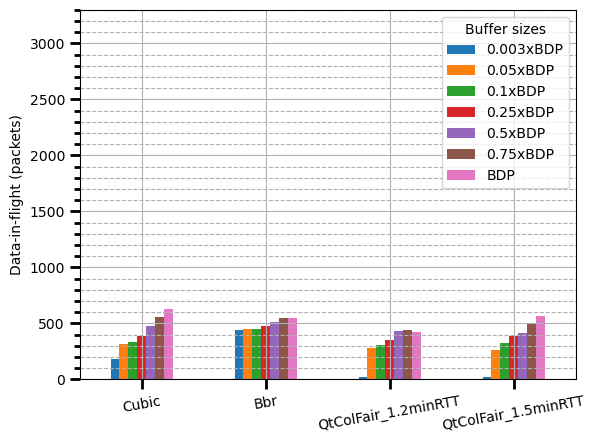

In [17]:
inflight1 = [agg_inflight_mean[0][0][0], agg_inflight_mean[1][0][0], agg_inflight_mean[2][0][0], 
         agg_inflight_mean[3][0][0]]
inflight17 = [agg_inflight_mean[0][1][0], agg_inflight_mean[1][1][0], agg_inflight_mean[2][1][0], 
         agg_inflight_mean[3][1][0]]
inflight34 = [agg_inflight_mean[0][2][0], agg_inflight_mean[1][2][0], agg_inflight_mean[2][2][0], 
         agg_inflight_mean[3][2][0]]
inflight86 = [agg_inflight_mean[0][3][0], agg_inflight_mean[1][3][0], agg_inflight_mean[2][3][0], 
         agg_inflight_mean[3][3][0]]
inflight172 = [agg_inflight_mean[0][4][0], agg_inflight_mean[1][4][0], agg_inflight_mean[2][4][0], 
         agg_inflight_mean[3][4][0]]
inflight259 = [agg_inflight_mean[0][5][0], agg_inflight_mean[1][5][0], agg_inflight_mean[2][5][0], 
         agg_inflight_mean[3][5][0]]
inflight345 = [agg_inflight_mean[0][6][0], agg_inflight_mean[1][6][0], agg_inflight_mean[2][6][0], 
         agg_inflight_mean[3][6][0]]

index = [
            tcp_cca[0].replace('Tcp',''),
            tcp_cca[1].replace('Tcp',''),
            tcp_cca[2].replace('mininflight','').replace('Tcp',''),
            tcp_cca[3].replace('mininflight','').replace('Tcp','')
]

df = pd.DataFrame({'0': inflight1, '1': inflight17, '2': inflight34, '3': inflight86, 
                   '4': inflight172, '5': inflight259, '6': inflight345
                  }, index=index)

ax1 = df.plot.bar(rot=10)

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.grid(b=True, which='minor', linestyle='--')

plt.legend(['0.003xBDP', '0.05xBDP', '0.1xBDP', '0.25xBDP', '0.5xBDP', '0.75xBDP', 'BDP'], 
           loc ="best", title = 'Buffer sizes')

plt.ylabel(r'Data-in-flight (packets)')
#plt.xscale('log')
#plt.xticks(x,values)
#plt.yscale('log')
plt.ylim(0,3300)
#plt.xlim(0,15)
plt.grid(True)

plt.savefig('multiple_bdp_comparison/5_flows_bdpshallow_inflight_barchart.png', transparent=True)
plt.show()